In [1]:
options(warn = -1)

In [2]:
library(lubridate)
library(rgdal)


Attaching package: 'lubridate'


The following objects are masked from 'package:base':

    date, intersect, setdiff, union


Loading required package: sp

rgdal: version: 1.5-23, (SVN revision 1121)
Geospatial Data Abstraction Library extensions to R successfully loaded
Loaded GDAL runtime: GDAL 3.2.1, released 2020/12/29
Path to GDAL shared files: C:/Users/clid1852/Documents/R/win-library/4.0/rgdal/gdal
GDAL binary built with GEOS: TRUE 
Loaded PROJ runtime: Rel. 7.2.1, January 1st, 2021, [PJ_VERSION: 721]
Path to PROJ shared files: C:/Users/clid1852/Documents/R/win-library/4.0/rgdal/proj
PROJ CDN enabled: TRUE
Linking to sp version:1.4-5
To mute warnings of possible GDAL/OSR exportToProj4() degradation,
use options("rgdal_show_exportToProj4_warnings"="none") before loading rgdal.
Overwritten PROJ_LIB was C:/Users/clid1852/Documents/R/win-library/4.0/rgdal/proj



In [3]:
inpath <- 'T:/Data/COUNTS/Nonmotorized Counts/Summary Tables/Bicycle/'

In [4]:
rawdata <- read.csv(paste0(inpath, 'Bicycle_HourlyForTableau.csv'))

In [5]:
names(rawdata)

[1] "Direction"       "ObsHours"        "Location"        "LocationId"     
 [5] "Day"             "Month"           "MonthDesc"       "Year"           
 [9] "Date"            "Season"          "Weekday"         "IsHoliday"      
[13] "Period"          "DailyCounts"     "IsOneway"        "OnewayDirection"
[17] "IsSidewalk"      "UoInSession"     "IsSpecialEvent"  "UniqueId"       
[21] "Hour"            "Hourly_Count"

In [6]:
rawdata$Season <- ifelse(rawdata$MonthDesc == "September", "Fall", rawdata$Season)

In [7]:
year <- 2021

In [23]:
data <- rawdata[rawdata$Year == year & rawdata$Direction == "Total" & data$ObsHours == 24,]

In [9]:
locdata <- read.csv("T:/Data/COUNTS/Nonmotorized Counts/Supporting Data/Supporting Bicycle Data/CountLocationInformation.csv")

In [10]:
names(locdata)

[1] "LocationId"           "CountType"            "Direction"           
 [4] "FacilityType"         "ArrowAngle"           "RoadWidth"           
 [7] "IsAutomatic"          "Location"             "HasData"             
[10] "City"                 "DoubleCountLocation"  "IsOneway"            
[13] "OnewayDirection"      "IsSidewalk"           "Latitude"            
[16] "Longitude"            "ImageFilePath"        "Site_Name"           
[19] "Location_Description" "TAZ"                  "Visual"

In [95]:
locvars <- c('CountType', 'Direction', 'FacilityType', 'RoadWidth', 'City', 
             'Location', 'Latitude', 'Longitude', 'Site_Name', 
             'DoubleCountLocation', 'IsOneway', 'OnewayDirection', 
             'IsSidewalk', 'Location_Description')

In [28]:
data$Date <- as.Date(data$Date, "%Y-%m-%d")

In [96]:
aggdata <- aggregate(x=list(DailyCounts = data$Hourly_Count), 
                     by=list(Date = data$Date, Location = data$Location), 
                     FUN=sum, na.rm=TRUE)

In [97]:
no_days <- aggregate(x=list(ObsDays = data$Date), 
                     by=list(Location = data$Location), 
                     FUN=function(x) length(unique(x)))

In [79]:
datedata <- unique(data[,c("Date", "Month", "MonthDesc", "Season", "Weekday", "IsHoliday", "UoInSession", "IsSpecialEvent")])

In [98]:
ave_daily_cnt <- aggregate(x=list(AveDailyCnt = aggdata$DailyCounts), 
                     by=list(Location = aggdata$Location), 
                     FUN=mean)

In [99]:
AveDailyCnt <- merge(ave_daily_cnt, no_days, by="Location")

In [100]:
AveDailyCnt <- merge(AveDailyCnt, locdata[,locvars], by = 'Location')

In [101]:
AveDailyCnt$Pct <- AveDailyCnt$ObsDays / 3.65

In [92]:
dim(AveDailyCnt[AveDailyCnt$ObsDays == 365,])[1]/dim(AveDailyCnt)[1]

[1] 0.1044776

In [116]:
AveDailyCnt[AveDailyCnt$ObsDays == 365,"Site_Name"]

[1] "Alder St North of 18th Ave"                        
[2] "Alder St South of Franklin Blvd"                   
[3] "EWEB Path East of 5th St"                          
[4] "Fern Ridge Path East of Commerace Connector Bridge"
[5] "Frohnmayer Bridge south Terminus"                  
[6] "Rosa Parks Path South of Q St"                     
[7] "Southbank Path West of Knickerbocker Bridge"

In [102]:
aggdata <- merge(aggdata, datedata, by="Date")

In [103]:
aggdata <- merge(aggdata, locdata[,locvars], by = 'Location')

In [104]:
aggdata$SeasonOrder <- ifelse(aggdata$Season == "Spring", 1, 
                              ifelse(aggdata$Season == "Summer", 2, 
                                     ifelse(aggdata$Season == "Fall", 3, 4)))

In [105]:
aggdata$WeekdayOrder <- ifelse(aggdata$Weekday == "Monday", 1, 
                              ifelse(aggdata$Weekday == "Tuesday", 2, 
                                     ifelse(aggdata$Weekday == "Wednesday", 3, 
                                     ifelse(aggdata$Weekday == "Thursday", 4, 
                                            ifelse(aggdata$Weekday == "Friday", 5, 
                                                ifelse(aggdata$Weekday == "Saturday", 6, 7))))))

In [64]:
outpath <- "T:/DCProjects/StoryMap/BikeCounting/BikeCounts/Output"

In [106]:
write.csv(aggdata, paste0(outpath, "/Daily_Bike_Counts_", year, ".csv"), row.names = FALSE)

In [66]:
MPOBound <- readOGR(dsn = "V:/Data/Transportation", layer="MPO_Bound")

OGR data source with driver: ESRI Shapefile 
Source: "V:\Data\Transportation", layer: "MPO_Bound"
with 1 features
It has 3 fields


In [67]:
# require MPOBound
df2spdf <- function(df, lon_col_name, lat_col_name, trans = TRUE){
  lonlat <- sp::CRS("+proj=longlat +datum=WGS84 +ellps=WGS84 +towgs84=0,0,0")
  lon_col_no <- which(names(df)==lon_col_name)
  lat_col_no <- which(names(df)==lat_col_name)
  xy <- data.frame(df[,c(lon_col_no,lat_col_no)])
  coordinates(xy) <- c(lon_col_name, lat_col_name)
  proj4string(xy) <- lonlat
  spdf <- sp::SpatialPointsDataFrame(coords = xy, data = df)
  if(trans){
    spdf <- spTransform(spdf, CRS(proj4string(MPOBound)))
  }
  return(spdf)
}

In [107]:
aggspdf <- df2spdf(aggdata, 'Longitude', 'Latitude')

In [108]:
writeOGR(aggspdf, dsn=outpath, layer=paste0("Daily_Bike_Counts_", year), 
         driver="ESRI Shapefile", overwrite_layer=TRUE)

In [109]:
AveDailyCnt_spdf <- df2spdf(AveDailyCnt, 'Longitude', 'Latitude')

In [110]:
writeOGR(AveDailyCnt_spdf, dsn=outpath, layer=paste0("Mean_Daily_Bike_Counts_", year), 
         driver="ESRI Shapefile", overwrite_layer=TRUE)

In [111]:
names(aggdata)

[1] "Location"             "Date"                 "DailyCounts"         
 [4] "Month"                "MonthDesc"            "Season"              
 [7] "Weekday"              "IsHoliday"            "UoInSession"         
[10] "IsSpecialEvent"       "CountType"            "Direction"           
[13] "FacilityType"         "RoadWidth"            "City"                
[16] "Latitude"             "Longitude"            "Site_Name"           
[19] "DoubleCountLocation"  "IsOneway"             "OnewayDirection"     
[22] "IsSidewalk"           "Location_Description" "SeasonOrder"         
[25] "WeekdayOrder"

In [73]:
dim(aggdata)

[1] 5975   17

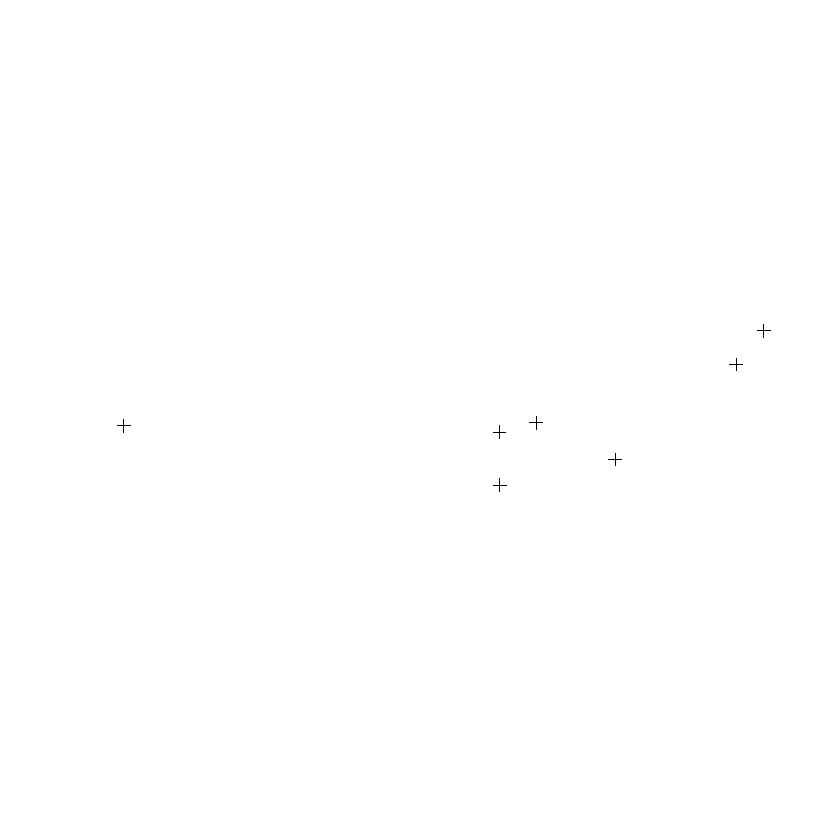

In [94]:
plot(AveDailyCnt_spdf[AveDailyCnt_spdf$ObsDays == 365,])

In [112]:
unique(AveDailyCnt_spdf$CountType)

[1] "Manual"    "Permanent"

In [115]:
AveDailyCnt[AveDailyCnt$CountType == 'Permanent', 'Site_Name']

[1] "Alder St North of 18th Ave"                        
[2] "Delta Ponds Path west of Goodpasture Island Rd"    
[3] "EWEB Path East of 5th St"                          
[4] "Fern Ridge Path East of Commerace Connector Bridge"
[5] "Fern Ridge Path West of Chambers St"               
[6] "Greenway Bridge"                                   
[7] "Jessen Path West of Golden Gardens St"             
[8] "North Bank Trail East of River Hills Dr"           
[9] "Southbank Path West of Knickerbocker Bridge"